In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
import os
import numpy as np
from scipy.special import beta as BETA
import time
import math
import torch
from torch.optim.optimizer import Optimizer

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

torch.autograd.set_detect_anomaly(True)
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

In [3]:
class IBP:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def rand(self, n, k_max):
        Z = []
        for i in range(n):
            nu = torch.distributions.beta.Beta(self.alpha,1).sample([k_max,1])
            p = self.break_stick_ibp(nu)
            z = torch.distributions.bernoulli.Bernoulli(p).sample().view(1,-1)
            Z.append(z)
        
        Z = torch.cat(Z, 0)
        return Z
    
    def rand_nu(self, nu, n= 1):
        p = self.break_stick_ibp(nu)
        Z = torch.distributions.bernoulli.Bernoulli(p).sample([n])
        return Z
    
    def break_stick_ibp(self, nu):
        K_max = nu.shape[0]
        p = []
        p.append(nu[0,:])
        for k in range(1,K_max):
            p.append(p[k-1]*nu[k,:])
        
        p = torch.cat(p,0)
        return p
        
    def break_log_stick_ibp(self, lognu):
        K_max = nu.shape[0]
        logp = []
        logp.append(lognu[0,:])
        for k in range(1,K_max):
            logp.append(logp[k-1] + lognu[k,:])
        
        logp = torch.cat(logp, 0)
        return logp

In [5]:
class Adam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data#.clamp(-10,10)
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros_like(p.data)
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                val = (grad!=0).float()
                state['step'] += 1# val

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2.pow(0.5)) / bias_correction1

                p.data += -step_size*(exp_avg.div(denom))

        return loss

In [6]:
# training
BATCH_SIZE = 100
if(os.path.isdir(os.path.join(os.getcwd(), 'data'))):
    trainset = datasets.MNIST('./data/', train=True, download=False,
                   transform=transforms.ToTensor())
else:
    trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("Done !")

Done !


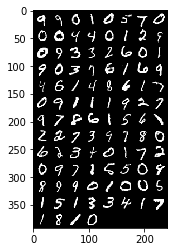

In [8]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [9]:
class stochasticIBP(nn.Module):
    '''
    This is a stochastic IBP layer with unlimited size of input output nodes.
    '''
    def __init__(self, in_features, out_features, bias = True, alpha = 4.0, beta = 1.0, fix = [False, False]):
        super(stochasticIBP, self).__init__()
        '''
        in_features : initial_input_size
        out_features : initial_output_size
        '''
        self.alpha = alpha
        self.beta = beta
        self.in_features = in_features
        self.out_features = out_features
        self.eps = 10e-10
        
        self.fix_in = fix[0]
        self.fix_out = fix[1]
        
        # Lazy initialization of parameters
        self.weight = nn.Parameter(torch.randn(self.in_features, self.out_features)*self.eps)
        self.weight_std = nn.Parameter(torch.randn(self.in_features, self.out_features)*self.eps)
        if bias:
            self.bias = nn.Parameter(torch.randn(self.out_features, 1)*self.eps)
            self.bias_std = nn.Parameter(torch.randn(self.out_features, 1)*self.eps)
        else:
            self.bias = torch.randn(self.out_features, 1)*0
            self.bias_std = torch.randn(self.out_features, 1)*0
            
        self.reset_parameters()
        
        self.beta_a = nn.Parameter(torch.zeros(self.out_features, 1) 
                                 + self.inv_softplus(self.alpha) + 
                                 torch.rand(self.out_features,1)*self.eps)
        self.beta_b = nn.Parameter(torch.zeros(self.out_features, 1) 
                                 + self.inv_softplus(torch.tensor(self.beta)) + 
                                 torch.rand(self.out_features,1)*self.eps)
        
        self.euler_constant = -torch.digamma(torch.tensor(1.0))
        
        # Gumbel Bernoulli
        self.phi = nn.Parameter(torch.randn((self.in_features + 1),self.out_features)*self.eps)
        self.temperature = torch.zeros(self.out_features, 1) + 10
        self.t_prior = 0.1 # prior temperature
        
        # RRS
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.curr_out = self.out_features
        
        

    def inv_softplus(self, alpha):
        with torch.no_grad():
            mask = (alpha <= 20).float()
            
        ret = alpha*(1-mask) + torch.log(torch.exp(alpha) - 1)*mask
        return ret
        
    def softplus(self, x):
        with torch.no_grad():
            mask = (x <= 20).float()
        ret = x*(1-mask) + torch.log(torch.exp(x) + 1)*mask
        return ret
    
    def forward(self, input, k = 0, sample_size = 1, store_KL = False):
        ################## this the layers functional part
        x = input.view(-1, self.in_features)
        N, D = x.shape
        
        if(k == 0):
            k = self.curr_out
        
        mu = F.linear(x, self.weight[:k,:]) + self.bias[:k,:].view(-1,k) # N x k
        log_var = F.linear(x, self.weight_std[:k,:]) + self.bias_std[:k,:].view(-1,k) # N x k
        
        ################## Gaussian reparameterization...............
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s)
        a = eps.mul(s).add_(mu)
        
        x_cat = torch.cat((x, torch.ones(N).view(N,-1)), 1).view(N,D+1) # N x D+1 
        inter_z = torch.mm(x_cat, self.phi[:,:k]) # N x k
    
        ################## Reparameterized gumbel kumaraswamy part........
        G1 = torch.distributions.uniform.Uniform(self.eps, 
                                1-self.eps).sample([N,k,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
            
        ## Sampling the Nu's with stick breaking IBP
        a = self.softplus(self.beta_a[:k,:]).view(k,1)
        b = self.softplus(self.beta_b[:k,:]).view(k,1)
        U = torch.distributions.uniform.Uniform(self.eps, 
                                1-self.eps).sample([k,sample_size])
        nu = (1-(U+self.eps).pow(1/a) + self.eps).pow(1/b).view(1,-1, sample_size)[0]
        
        K_max = nu.shape[0]
        p = []
        p.append(nu[0,:])
        for t in range(1,K_max):
            p.append(p[t-1]*nu[t,:])
        p = torch.cat(p,0)
        
        pi = orch.distributions.bernoulli.Bernoulli(p).sample([N])
        logit_pi = ((pi + self.eps)/(1-pi + self.eps)).log()
        logit_alpha = logit_pi + inter_z.view(N,k,1)
        alpha = logit_alpha.sigmoid()
        
        z1 = (logit_alpha + logit_G1)/self.temperature[:K,:].view(1,K,1)
        z = z1.sigmoid()
        
        code = a*z # N x k   : this will the output of the network.....
        
        if(not store_KL):    
            return code 
        
#         '''The forward pass of model is complete we just need KL divergences now...'''
#         ################### Calculation of KL divergence for this layer with priors.....
#         curr_K = self.curr_out
        
        
        # gi : alpha, py : nu
        
        
        

In [ ]:
class APIC(nn.Module):
    def __init__(self, latent_variable_dim, prior , rholr = 10e-12, lr = 0.01):
        super(APIC, self).__init__()
        
        alpha = prior.alpha
        self.prior = prior
        self.print = False
        self.sp = torch.nn.Softplus(threshold = 20)
        
        ### Global Params
        self.eps1 = torch.tensor(10e-6).float()
        self.eps2 = torch.tensor(10e-4).float()
        self.lr = lr
        self.D = 784
    
        # Encoder
        self.h_dim = 400
        self.fc1 = nn.Linear(self.D,self.h_dim,'relu')
        
        self.weight_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, self.h_dim)*0.0001*self.eps1)
        self.weight_enc_std = nn.Parameter(torch.randn(latent_variable_dim, self.h_dim)*0.0001*self.eps1)
        self.bias_enc_mean = nn.Parameter(torch.randn(latent_variable_dim, 1)*0.0001*self.eps1)
        self.bias_enc_std = nn.Parameter(torch.randn(latent_variable_dim, 1)*0.0001*self.eps1)
        
        
        # Decoder
        self.weight_dec_code = nn.Parameter(torch.randn(self.h_dim, latent_variable_dim, )*0.0001*self.eps1)
        self.bias_dec_code = nn.Parameter(torch.randn(self.h_dim, 1)*0.0001*self.eps1)
        self.fc2 = nn.Linear(self.h_dim,self.D,'linear')
        
        
        # structured SBC
        self.aeys = nn.Parameter(torch.zeros(latent_variable_dim, 1) + self.inv_softplus(alpha) + torch.rand(latent_variable_dim,1)*0.0001*self.eps1)
        self.bees = nn.Parameter(torch.zeros(latent_variable_dim, 1) + self.inv_softplus(torch.tensor(1.0)) + torch.rand(latent_variable_dim,1)*0.0001*self.eps1)
        self.alpha = alpha
        self.beta = 1.0
        
        
        self.unif_sampler = torch.distributions.uniform.Uniform(self.eps1, 1-self.eps1)
        self.euler_constant = -torch.digamma(torch.tensor(1.0))
        
        # Z : GumbelBernoulli
        self.phi = nn.Parameter(torch.randn((self.h_dim + 1),latent_variable_dim)*0.0001*self.eps1)
        self.temperature = torch.zeros(latent_variable_dim, 1) + 10
        self.t_prior = 0.1 # prior lambda

        ### Russian Roulette part
        self.rhos = torch.zeros(latent_variable_dim + 1,1) + 0.5
        self.rholr = rholr
        
        ## Optimizer
        self.optimizer = None
        self.K = latent_variable_dim
        self.max_K = latent_variable_dim
        
        
        
                             
    def inv_softplus(self, alpha):
#         return self.sp(alpha)
        with torch.no_grad():
            mask = (alpha <= 20).float()
            
        ret = alpha*(1-mask) + torch.log(torch.exp(alpha) - 1)*mask
        return ret
        
    def softplus(self, x):
#         return torch.log(torch.exp(x) + 1)
        with torch.no_grad():
            mask = (x <= 20).float()
        ret = x*(1-mask) + torch.log(torch.exp(x) + 1)*mask
        return ret
    
    def sample_nupi(self, N, K, sample_size = 1):
        
        a = self.softplus(self.aeys)[:K,:].view(K,1)
        b = self.softplus(self.bees)[:K,:].view(K,1)
        
        U = self.unif_sampler.sample([K,sample_size])
        nu = (1-(U+self.eps1).pow(1/a) + self.eps1 ).pow(1/b).view(1,-1, sample_size)[0]
        py = self.prior.rand_nu(nu, N).view(N,-1, sample_size)
        
        return nu, py
        
    
    def GumbelBernoulliLogitLazyDense(self, x, k):
        
        N, D = x.shape
        
        x_cat = torch.cat((x.view(N,self.h_dim), torch.ones(N).view(N,-1)), 1).view(N,D+1)
        inter_z = torch.mm(x_cat, self.phi[:,:k])
        z, gi, pi, py = self.reparameterize_gumbel_kumaraswamy(inter_z, k) # N x K
        return z, gi, pi, py
        
    def reparameterize_gaussian(self, log_var, mu):
        s = torch.exp(0.5*log_var)
        eps = torch.rand_like(s) # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
    
    def reparameterize_gumbel_kumaraswamy(self, inter_z, p):
        '''Proper Sampling is required with masking'''
        
        N, K = inter_z.shape
        sample_size = 1
        
        G1 = self.unif_sampler.sample([N,K,sample_size])
        logit_G1 = G1.log() - (1-G1).log() 
        
        nu, pi = self.sample_nupi(N, K,sample_size) # K x sample_size
        
        logit_pi = ((pi + self.eps1)/(1-pi + self.eps1)).log()
        logit_alpha = logit_pi + inter_z.view(N,K,1)
        alpha = logit_alpha.sigmoid()
        
        z1 = (logit_alpha + logit_G1)/self.temperature[:K,:].view(1,K,1)
        y = z1.sigmoid()
        
        return y, alpha, pi, nu
        
    def forward(self, input, k):
        x = input.view(-1, self.D)
        N, D = x.shape
        
        if(k == 0):
            k = self.get_current_K()
            
        z, gi, pi, py, a, mu, log_var = self.encode(x,k)
        x = self.decode(a, z.mean(dim=-1).view(N,k), k)
        return x, z, gi, pi, py, a, mu, log_var
    
    
    def encode(self, x, k):
        
        h = self.fc1(x)
        log_s = ((F.linear(h, self.weight_enc_std[:k,:]) + self.bias_enc_std[:k,:].view(-1,k))/100)#.clamp(0,100)
        mu = F.linear(h, self.weight_enc_mean[:k,:]) + self.bias_enc_mean[:k,:].view(-1,k)
        
        a = self.reparameterize_gaussian(log_s, mu) # N x K
        
        z, gi, pi, py = self.GumbelBernoulliLogitLazyDense(h, k)
        return z,gi,pi,py,a,mu,log_s

    
    def decode(self, a, z, k):
        
        code = a*z
        x = F.linear(code, self.weight_dec_code[:,:k]) + self.bias_dec_code.view(-1,self.h_dim)
        x = F.relu(x)
        x = self.fc2(x).sigmoid()
        
        return x
    
    
    def add_k_node(self, k):
        
        # Add k latent features ...
        if(k == 0):
            return 
        with torch.no_grad():
            self.aeys = nn.Parameter(torch.cat((self.aeys, torch.rand(k,1)*0.0001*self.eps1 + self.softplus(self.alpha)), 0))
            self.bees = nn.Parameter(torch.cat((self.bees, torch.rand(k,1)*0.0001*self.eps1 + self.softplus(torch.tensor(1.0))), 0))
            
            self.phi = nn.Parameter(torch.cat((self.phi, torch.randn((self.h_dim + 1),k)), 1))
            self.weight_enc_mean = nn.Parameter(torch.cat((self.weight_enc_mean, torch.randn(k, self.h_dim)), 0)*0.0001*self.eps1)
            self.weight_enc_std = nn.Parameter(torch.cat((self.weight_enc_std, torch.randn(k, self.h_dim)), 0)*0.0001*self.eps1)
            
            self.bias_enc_mean = nn.Parameter(torch.cat((self.bias_enc_mean, torch.randn(k, 1)), 0)*0.0001*self.eps1)
            self.bias_enc_std = nn.Parameter(torch.cat((self.bias_enc_std, torch.randn(k, 1)), 0)*0.0001*self.eps1)
            
            self.weight_dec_code = nn.Parameter(torch.cat((self.weight_dec_code, torch.randn(self.h_dim,k)), 1)*0.0001*self.eps1)
            
            self.rhos = torch.cat((self.rhos, torch.zeros(k,1) + 0.5), 0)
            self.temperature = torch.cat((self.temperature, torch.zeros(k,1) + 10.0), 0)
            
            
    
    def del_k_node(self, k):
        
        # Retain k Latent Features ...
        if(k == 0 or k == self.get_current_K()):
            return
        with torch.no_grad():
            c_K = self.get_current_K()
            
            self.aeys = nn.Parameter(list(torch.split(self.aeys, c_K - k , 0))[0])
            self.bees = nn.Parameter(list(torch.split(self.bees, c_K - k , 0))[0])
            
            self.phi = nn.Parameter(list(torch.split(self.phi, c_K - k , 1))[0])
            self.weight_enc_mean = nn.Parameter(list(torch.split(self.weight_enc_mean, c_K - k , 0))[0])
            self.weight_enc_std = nn.Parameter(list(torch.split(self.weight_enc_std, c_K - k , 0))[0])
            self.weight_dec_code = nn.Parameter(list(torch.split(self.weight_dec_code, c_K - k , 1))[0])
            
            self.rhos = list(torch.split(self.rhos, c_K - k + 1, 0))[0]
                             
    def get_current_K(self):
        return self.K
    
    def constraint_proj(self):
        with torch.no_grad():
            self.aeys[self.aeys < 0.1] = 0.1
            self.bees[self.bees < 0.1] = 0.1
            self.rhos[self.rhos < 10e-6] = 10e-6
            self.rhos[self.rhos > 1 - 10e-6] = 1 - 10e-6
            pass
        
    def dynamize_Adam(self, reset = False, amsgrad = True):
        with torch.no_grad():
            if(reset or self.optimizer == None):
                self.optimizer = Adam(self.parameters(), self.lr, amsgrad = amsgrad)
                self.optimizer.step()
            else:
                optim = self.optimizer
                newoptim = Adam(self.parameters(), self.lr)

                for i in range(len(optim.param_groups)):
                    group_old = optim.param_groups[i]
                    group_new = newoptim.param_groups[i]

                    for j in range(len(group_old['params'])):
                        params_old = group_old['params'][j]
                        params_new = group_new['params'][j]

                        amsgrad = group_old['amsgrad']
                        newoptim.param_groups[i]['amsgrad'] = amsgrad


                        state_old = optim.state[params_old]
                        state_new = newoptim.state[params_new]

                        state_new['step'] = torch.zeros_like(params_new.data)

                        state_new['exp_avg'] = torch.zeros_like(params_new.data)
                        state_new['exp_avg_sq'] = torch.zeros_like(params_new.data)



                        exp_avg = state_new['exp_avg']
                        exp_avg_sq = state_new['exp_avg_sq']
                        max_exp_avg_sq = None
                        if(amsgrad):
                            state_new['max_exp_avg_sq'] = torch.zeros_like(params_new.data)
                            max_exp_avg_sq = state_new['max_exp_avg_sq']
                            
                        if(len(state_old) == 0):
                            pass
                        else:
                            if(len(state_old['exp_avg'].shape)==2):
                                no,do = state_old['exp_avg'].shape
                                exp_avg[:no,:do] = state_old['exp_avg']
                                exp_avg_sq[:no,:do] = state_old['exp_avg_sq']
                                if(max_exp_avg_sq is not None):
                                    max_exp_avg_sq[:no,:do] = state_old['max_exp_avg_sq']
                                state_new['step'][:no,:do] = state_old['step']

                            elif(len(state_old['exp_avg'].shape)==1):
                                no = state_old['exp_avg'].shape[0]
                                exp_avg[:no] = state_old['exp_avg']
                                exp_avg_sq[:no] = state_old['exp_avg_sq']
                                if(max_exp_avg_sq is not None):
                                    max_exp_avg_sq[:no] = state_old['max_exp_avg_sq']
                                state_new['step'][:no] = state_old['step']

                            else:
                                assert 1 == 2 ,'error in dynamic adam'

                        state_new['exp_avg'] = exp_avg
                        state_new['exp_avg_sq'] = exp_avg_sq

                        newoptim.state[params_new] = state_new
                    
                self.optimizer = newoptim